In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt 

%matplotlib inline

In [19]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        out = Value(self.data + other.data, _children=(self, other), _op='+')
        def _backward():
            # need to accumulate gradients rather than overwrite them for the case we use a node multiple times
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float values"
        out = Value(self.data**other, (self,), f'**{other}')

        def backward():
            self.grad += other * self.data**(other - 1) * out.grad
        out._backward = backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(data=other)
        out = Value(self.data * other.data, _children=(self, other), _op='*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, _children=(self, ), _op='tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v: Value):
            if v not in visited:
                visited.add(v)
                for prev in v.prev:
                    build_topo(prev)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for n in reversed(topo):
            n._backward()

In [4]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label="{ %s | data:%.4f | grad:%.4f}"%(n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

In [5]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

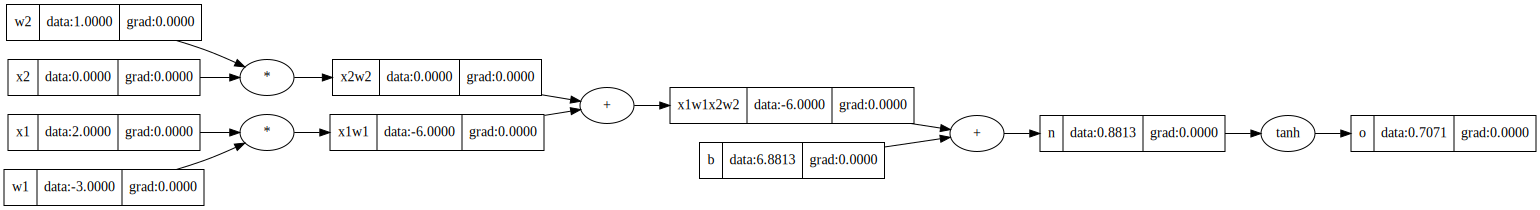

In [6]:
draw_dot(o)

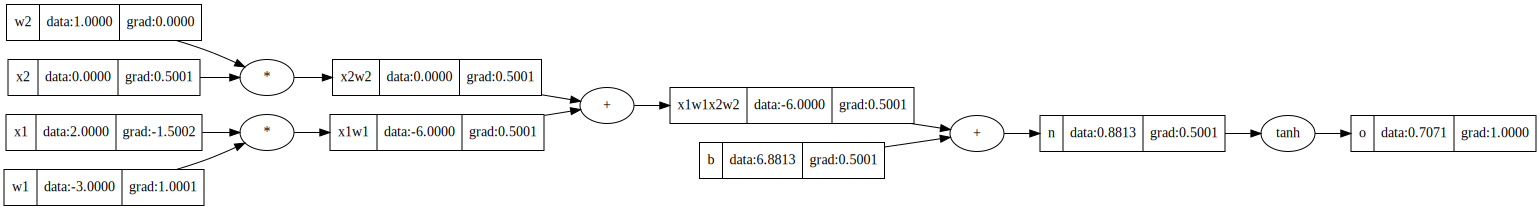

In [7]:
o.backward()
draw_dot(o)

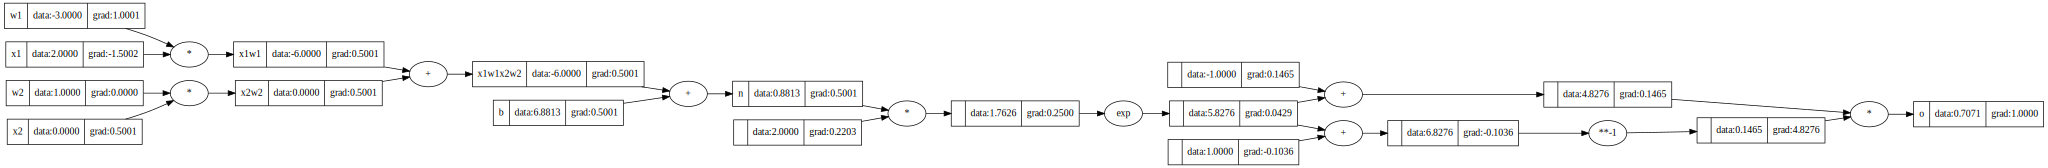

In [20]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e - 1)/(e + 1) ; o.label = 'o'

o.backward()
draw_dot(o)

In [14]:
# Doing exactly the same thing, but in Pytorch as an exercise
import torch

In [22]:
x1 = torch.tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.tensor([0.0]).double() ; x2.requires_grad = True

w1 = torch.tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.tensor([1.0]).double() ; w2.requires_grad = True

b = torch.tensor([6.8813]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward() 

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7070699720278941
----
x2 0.5000520546564731
w2 0.0
x1 -1.5001561639694192
w1 1.0001041093129461


In [25]:
import random

In [49]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [90]:
x = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.7534332185278485)

In [86]:
len(n.parameters())

41

In [91]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]

In [92]:
for k in range(20):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    # Zero grad
    for p in n.parameters():
        p.grad = 0.0
    # Backward pass
    loss.backward()
    # Update step
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(f"Trained {k} epochs. Loss is {loss.data}")

Trained 0 epochs. Loss is 5.359890021638628
Trained 1 epochs. Loss is 2.592664435243846
Trained 2 epochs. Loss is 1.7510822993569337
Trained 3 epochs. Loss is 0.9678179414595316
Trained 4 epochs. Loss is 0.4615509787688467
Trained 5 epochs. Loss is 0.26856254580225114
Trained 6 epochs. Loss is 0.1900458118414436
Trained 7 epochs. Loss is 0.14636504725834265
Trained 8 epochs. Loss is 0.11857996060397133
Trained 9 epochs. Loss is 0.09938044981966156
Trained 10 epochs. Loss is 0.08534345000635428
Trained 11 epochs. Loss is 0.0746502023326519
Trained 12 epochs. Loss is 0.06624455087908344
Trained 13 epochs. Loss is 0.0594712797715366
Trained 14 epochs. Loss is 0.05390253605723064
Trained 15 epochs. Loss is 0.04924724216971792
Trained 16 epochs. Loss is 0.04530060337927149
Trained 17 epochs. Loss is 0.04191442616417596
Trained 18 epochs. Loss is 0.03897888572983477
Trained 19 epochs. Loss is 0.03641090399705487


In [93]:
ypred

[Value(data=0.9102584724273655),
 Value(data=-0.9195583347020672),
 Value(data=-0.9015472441355022),
 Value(data=0.889575566232985)]